# Linear transformations with images
In this module we will work with linearly aligning images.  We'll apply transformations to images, and estimate optimal transformations.  Here problems will be nonlinear, and we'll need to use iterative methods.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

## Load some data

In [2]:
fname = os.path.join('T1Images','Adt27-55_02_Adt27-55_02_MNI.img')
img = nib.load(fname)
# get voxel voxel size and number of voxels
# note all the images in this dataset are in MNI space and are the same size and shape
nx = img.header['dim'][1:4]
dx = img.header['pixdim'][1:4]
# set up a domain
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')
# load the image
I = img.get_data()[:,:,:,0]

In [3]:
# simple function for drawing 3 slices
def draw_slices(x0,x1,x2,I,axlist=None,**kwargs):
    ''' Draw three slices through the middle of an image'''
    if axlist is None:
        f,axlist = plt.subplots(1,3)    
    defaults = {'cmap':'gray',
               'aspect':'equal',
               'interpolation':'none'}
    kwargs.update(defaults)
    
    h0 = axlist[0].imshow(np.squeeze(I[:,:,I.shape[2]//2]),extent=(x1[0],x1[-1],x0[0],x0[-1]),**kwargs)
    axlist[0].set_xlabel('x1')
    axlist[0].set_ylabel('x0')
    h1 = axlist[1].imshow(np.squeeze(I[:,I.shape[1]//2,:]),extent=(x2[0],x2[-1],x0[0],x0[-1]),**kwargs)
    axlist[1].set_xlabel('x2')
    axlist[1].set_ylabel('x0')
    h2 = axlist[2].imshow(np.squeeze(I[I.shape[0]//2,:,:]),extent=(x2[0],x2[-1],x1[0],x1[-1]),**kwargs)
    axlist[2].set_xlabel('x2')
    axlist[2].set_ylabel('x1')
    return [h0,h1,h2]

<IPython.core.display.Javascript object>


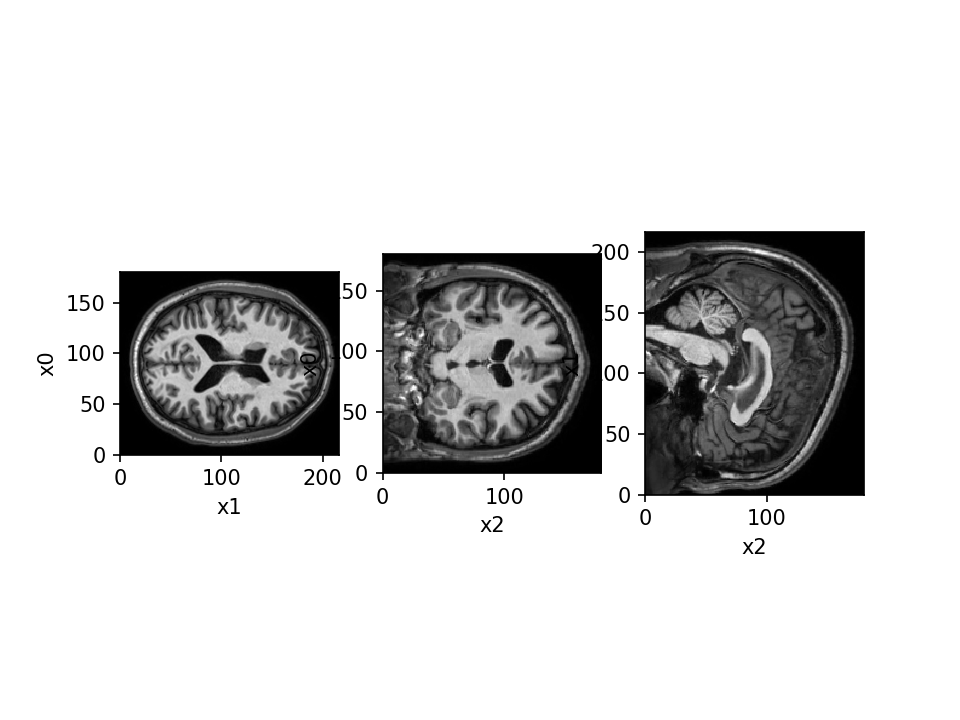

In [4]:
draw_slices(x0,x1,x2,I)

## Transformations act on images through their inverse

## Images are deformed by sampling them at new points: interpolation

<IPython.core.display.Javascript object>


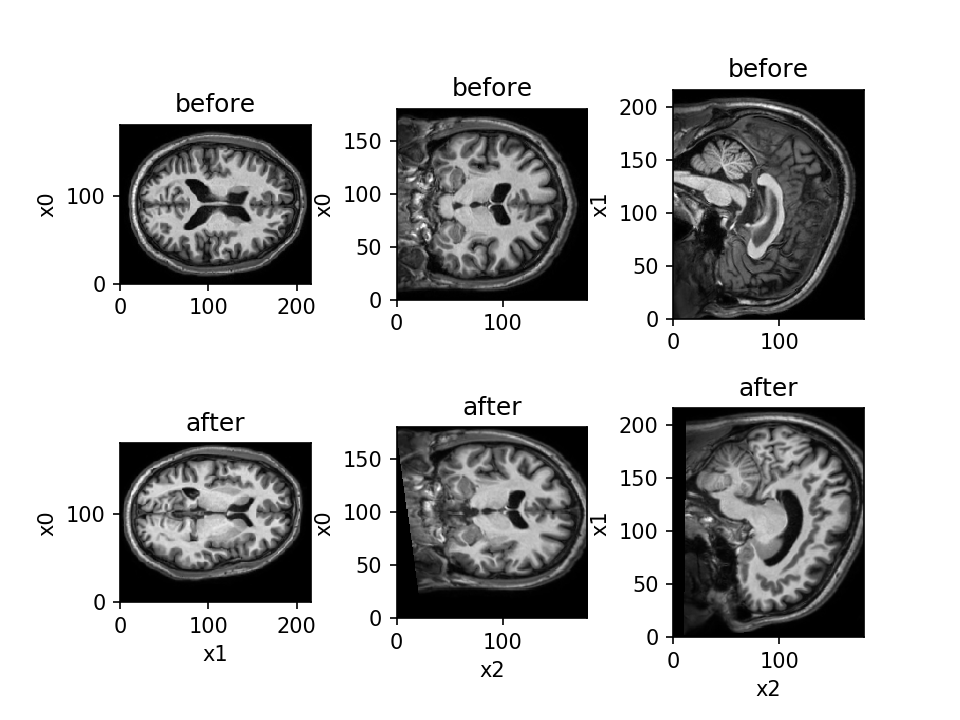

In [5]:
# construct a transformation
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation
A[:3,-1] += np.random.randn(3)*5.0 # a random shift
# find its inverse, using homogeneous coordinates
B = np.linalg.inv(A)
# get the sample points
X0s = B[0,0]*X0 + B[0,1]*X1 + B[0,2]*X2 + B[0,3]
X1s = B[1,0]*X0 + B[1,1]*X1 + B[1,2]*X2 + B[1,3]
X2s = B[2,0]*X0 + B[2,1]*X1 + B[2,2]*X2 + B[2,3]
rgi = spi.RegularGridInterpolator(
    points=[x0,x1,x2], # this labels where in space each voxel is
    values=I, # this says the intensity of the image at each voxel
    method='linear', # this says how we'd like to do interpolation, linear is fast and smooth
    bounds_error=False, # this
    fill_value=0)
# now evaluate the image at these points
AI = rgi((X0s,X1s,X2s))
f,ax=plt.subplots(2,3)
plt.subplots_adjust(wspace=0.45,hspace=0.35)
draw_slices(x0,x1,x2,I,ax[0])
for a in ax[0]: 
    a.set_title('before')
    a.set_xlabel('')
draw_slices(x0,x1,x2,AI,ax[1])
for a in ax[1]: a.set_title('after')
Irandom = AI

## Computing optimal transformations
As with points, we will write down a sum of square error cost
\begin{align*}
E(A) = \int_X \frac{1}{2}(I(A^{-1}x) - J(x))^2 dx
\end{align*}

And as before we'll take it's gradient with respect to $A$.  Since $A$ is a matrix, we'll consider an arbitrary perturbation to $A$, $A\mapsto A + \epsilon \delta A$, and take the gradient with respect to $\epsilon$ for any perturbation.
\begin{align*}
E(\epsilon) = \int_X \frac{1}{2}(I( (A + \epsilon \delta A)^{-1}x) - J(x))^2 dx
\end{align*}
We will use the fact that
\begin{align}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0} = \text{trace} \nabla E^T \delta A
\end{align}
This is just the definition of the directional derivative, as the gradient dot the directoin.

We are interested in
\begin{align*}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0}
\end{align*}

Let's attack this expression using the chain rule, first attack the square term
\begin{align*}
&= \int_X (I((A + \epsilon \delta A)^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
&=\int_X (I(A^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
\end{align*}
Now attack the image
\begin{align*}
&= \int_X (I(A^{-1}x) - J(x))  DI((A + \epsilon \delta A)^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}x dx \bigg|_{\epsilon = 0}\\
&= \int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}\bigg|_{\epsilon = 0} x dx \\
\end{align*}
Now the final term depends on taking the derivative of the inverse of a matrix.  Consider an arbitrary matrix $M$ that is a function of a parameter $t$.  We can work out the derivative of the inverse by
\begin{align*}
\frac{d}{dt}M^{-1}(t) &=\frac{d}{dt}\left( M^{-1}(t)M(t)M^{-1}(t) \right)\\
&= \frac{d}{dt}M^{-1}(t) M(t) M^{-1}(t) + M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t) + M^{-1}(t)M(t) \frac{d}{dt}M^{-1}(t)\\
 &=\frac{d}{dt}\left( M^{-1}(t)M(t)M^{-1}(t) \right)\\
&= \frac{d}{dt}M^{-1}(t) + M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t) + \frac{d}{dt}M^{-1}(t)\\
\end{align*}
Rearranging gives
\begin{align*}
\frac{d}{dt}M^{-1}(t) = - M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t)
\end{align*}
So in our problem we have
\begin{align*}
\frac{d}{dt}(A + \epsilon \delta A)^{-1} &= -(A + \epsilon \delta A)^{-1} \delta A (A + \epsilon \delta A)^{-1}
\end{align*}
Plugging this in with $\epsilon = 0$ gives the result
\begin{align*}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0} = -\int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) A^{-1}\delta A A^{-1} x dx 
\end{align*}
Finally we can simplify this by recalling that $D[I(A^{-1}x)] = DI(A^{-1}x)A^{-1}$, giving
\begin{align*}
= -\int_X (I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx 
\end{align*}
Finally to work out the gradient with respect to $A$, we have to write this expression as a gradient, dot $\delta A$.  Taking the dot product on matrices using the trace gives
\begin{align*}
&= -\int_X \text{trace}(I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx \\
&= -\int_X \text{trace}A^{-1} x (I(A^{-1}x) - J(x))  D[I(A^{-1}x)] dx \delta A
\end{align*}
which gives a gradient of 
\begin{align*}
-\int_X (I(A^{-1}x)-J) \nabla[I(A^{-1}x)](A^{-1}x)^Tdx
\end{align*}

<IPython.core.display.Javascript object>


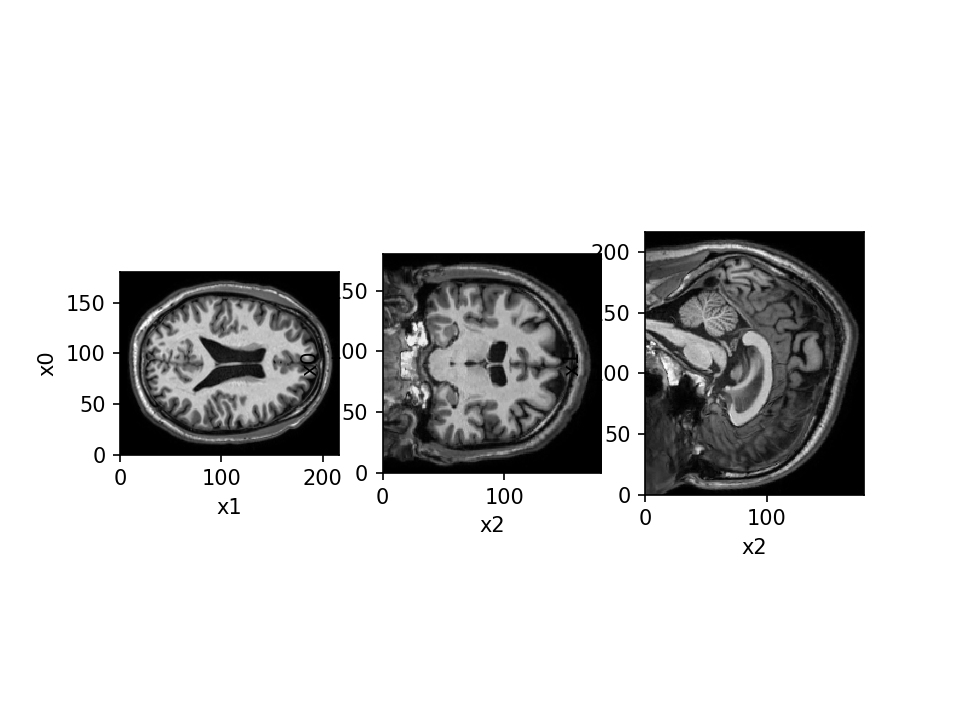

In [6]:
# load a second image
fname = os.path.join('T1Images','Adt27-55_03_Adt27-55_03_MNI.img')
img = nib.load(fname)
J = img.get_data()[:,:,:,0]
draw_slices(x0,x1,x2,J)

<IPython.core.display.Javascript object>


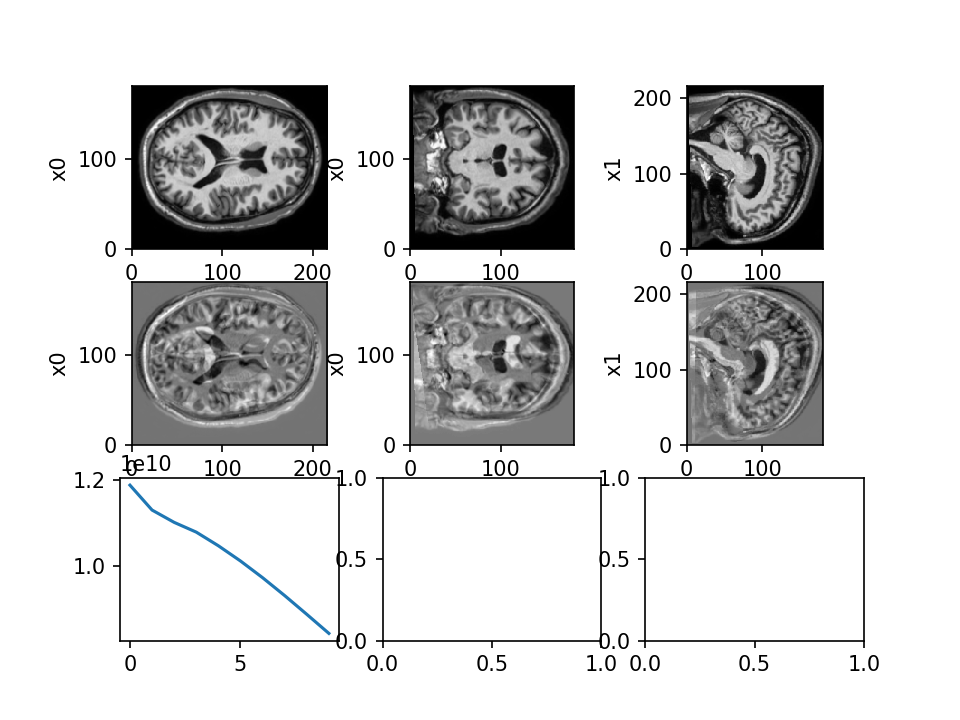

In [7]:
# since they are already affine aligned
I,J = J,Irandom
# initialize a transformation
A = np.eye(4)
epsilonL = 1.0e-13
epsilonT = 1.0e-9*0
niter = 10
EAll = []
f,ax = plt.subplots(3,3)
for it in range(niter):
    # find the deformed image
    B = np.linalg.inv(A)
    # get the sample points
    X0s = B[0,0]*X0 + B[0,1]*X1 + B[0,2]*X2 + B[0,3]
    X1s = B[1,0]*X0 + B[1,1]*X1 + B[1,2]*X2 + B[1,3]
    X2s = B[2,0]*X0 + B[2,1]*X1 + B[2,2]*X2 + B[2,3]
    rgi = spi.RegularGridInterpolator(
        points=[x0,x1,x2], # this labels where in space each voxel is
        values=I, # this says the intensity of the image at each voxel
        method='linear', # this says how we'd like to do interpolation, linear is fast and smooth
        bounds_error=False, # this
        fill_value=0)
    # now evaluate the image at these points
    AI = rgi((X0s,X1s,X2s))
    draw_slices(x0,x1,x2,AI,ax[0])
    # find the gradient
    AI_0,AI_1,AI_2 = np.gradient(AI,dx[0],dx[1],dx[2])
    # get the error
    err = AI-J
    draw_slices(x0,x1,x2,err,ax[1])
    # draw them
    # calculate energy
    E = np.sum(err**2*0.5)*np.prod(dx)
    EAll.append(E)
    ax[2,0].cla()
    ax[2,0].plot(EAll)
    # find the gradient of the linear part
    gradL = np.empty((3,3))
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        for j,AX_j in enumerate([X0s,X1s,X2s]):
            gradL[i,j] = -np.sum(err*AI_i*AX_j)*np.prod(dx)
    # find the gradient of the translation part
    gradT = np.empty(3)
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        gradT[i] = -np.sum(err*AI_i)*np.prod(dx)
    # update
    A[:3,:3] -= epsilonL*gradL
    A[:3,-1] -= epsilonT*gradT
    
    f.canvas.draw() # I may need ion
    
    